# Results Visualizations
> Ignorance is strength

In [ ]:
# hide
import blackhc.project.script

Appended /home/blackhc/PycharmProjects/bald-ical/src to paths
Switched to directory /home/blackhc/PycharmProjects/bald-ical
%load_ext autoreload
%autoreload 2


In [ ]:
import collections
import functools
import math
import os
import re
from collections import namedtuple
from dataclasses import dataclass
from typing import NamedTuple

import laaos

In [ ]:
# https://codereview.stackexchange.com/questions/85311/transform-snake-case-to-camelcase
def camel_case_name(snake_case_name):
    return re.sub("_([a-z])", lambda match: match.group(1).upper(), snake_case_name)


__namedtuples = {}


def to_namedtuple(obj, name):
    type_name = "_" + camel_case_name(name)
    if isinstance(obj, dict):
        keys = tuple(obj.keys())
        if keys in __namedtuples:
            nt = __namedtuples[keys]
        else:
            nt = namedtuple(type_name, keys)
            __namedtuples[keys] = nt
        return nt(*(to_namedtuple(v, k) for k, v in obj.items()))
    if isinstance(obj, list):
        item_type_name = type_name + "Item"
        return [to_namedtuple(item, item_type_name) for item in obj]
    if isinstance(obj, set):
        item_type_name = type_name + "Item"
        return {to_namedtuple(item, item_type_name) for item in obj}
    if isinstance(obj, tuple):
        item_type_name = type_name + "Item"
        return tuple(to_namedtuple(item, item_type_name) for item in obj)

    return obj


def get_any(d: dict):
    return next(iter(d.values()))


def handle_map_funcs(func_kv, func_k, func_v, default=None):
    if func_kv:
        assert func_k is None and func_v is None

        def inner(kv):
            return func_kv(*kv)

    elif func_k:
        assert func_v is None

        def inner(kv):
            return func_k(kv[0]), kv[1]

    elif func_v:

        def inner(kv):
            return kv[0], func_v(kv[1])

    else:
        return default
    return inner


def handle_unary_funcs(pred_kv, pred_k, pred_v, default=None):
    if pred_kv:
        assert pred_k is None and pred_v is None

        def inner(kv):
            return pred_kv(*kv)

    elif pred_k:
        assert pred_v is None

        def inner(kv):
            return pred_k(kv[0])

    elif pred_v:

        def inner(kv):
            return pred_v(kv[1])

    else:
        return default
    return inner


def map_dict(d: dict, *, kv=None, k=None, v=None):
    inner = handle_map_funcs(kv, k, v)
    return dict(map(inner, d.items()))


def filter_dict(d: dict, *, kv=None, k=None, v=None):
    inner_pred = handle_unary_funcs(kv, k, v)
    return dict(filter(inner_pred, d.items()))


def sort_dict(d: dict, *, reverse=False, kv=None, k=None, v=None):
    inner_key = handle_unary_funcs(kv, k, v, default=lambda ikv: ikv[0])
    return dict(sorted(d.items(), key=inner_key, reverse=reverse))


def groupby_dict(d: dict, *, key_kv=None, key_k=None, key_v=None, agg=None):
    inner_key = handle_unary_funcs(key_kv, key_k, key_v)

    grouped_by = {}
    for kv in d.items():
        new_key = inner_key(kv)
        if new_key not in grouped_by:
            grouped_by[new_key] = {}
        key, value = kv
        grouped_by[new_key][key] = value

    if agg is not None:
        return map_dict(grouped_by, v=agg)

    return grouped_by

In [ ]:
def get_laaos_files(laaos_dir=None):
    if laaos_dir is None:
        laaos_dir = "./batchbald_redux/results"

    laaos_files = {}
    for root, dirs, files in os.walk(laaos_dir, topdown=False):
        for name in files:
            if not name.endswith(".py"):
                continue

            rel_path = os.path.join(root, name)
            result_name = rel_path[len(laaos_dir) :]
            abs_path = os.path.abspath(rel_path)
            laaos_files[result_name] = abs_path

    return laaos_files


def load_laaos_files(path=None, files=None, vanilla=False, tag=None, prefix=None):
    if files is None:
        files = get_laaos_files(path)

    stores = {}
    for name, path in files.items():

        def nan():
            pass

        store = laaos.safe_load(path, exposed_symbols=[nan])
        store["actual_name"] = name
        store["actual_path"] = path
        store["tag"] = tag

        key = f"{prefix}{name}" if prefix is not None else name
        stores[key] = store

    if vanilla:
        return stores
    else:
        return map_dict(stores, v=functools.partial(to_namedtuple, name="Result"))

In [ ]:
results = load_laaos_files()

In [ ]:
get_any(results)

_Result(timestamp=1609769925, cmdline=['/auto/users/andsch/github/active_learning_redux/batchbald_redux/experiment.py', '--id', '37'], commit='808403cd2b48f26a866d0b4014e6ddacd13301f8', github_url='808403cd2b48f26a866d0b4014e6ddacd13301f8', experiment='/auto/users/andsch/github/active_learning_redux/batchbald_redux/experiment.py', job_id=37, worker_id=37, num_workers=120, config=_config(seed=38, acquisition_size=10, max_training_set=300, num_pool_samples=20, num_eval_samples=4, num_training_samples=1, num_patience_epochs=3, max_training_epochs=10, validation_set_size=4096, initial_set_size=20, samples_per_epoch=24576, repeated_mnist_repetitions=2, add_dataset_noise=True, acquisition_function='AcquisitionFunction.bald'), log=_log(), initial_training_set_indices=[38043, 40091, 17418, 2094, 39879, 3133, 5011, 40683, 54379, 24287, 9849, 59305, 39508, 39356, 8758, 52579, 13655, 7636, 21562, 41329], active_learning_steps=[_ActiveLearningStepsItem(training=_training(epochs=[_EpochsItem(accura

In [ ]:
experiment_data = []

for file, result in results.items():
    acquisition_size = result.config.acquisition_size
    acquisition_function = result.config.acquisition_function[len("AcquisitionFunction."):]

    if acquisition_function == "random":
        acquisition_sizes = [10,  5, 50, 20]
    else:
        acquisition_sizes = [acquisition_size]
    
    for acquisition_size in acquisition_sizes:
        initial_set_size = len(result.initial_training_set_indices)

        if initial_set_size + len(result.active_learning_steps) * result.config.acquisition_size < 300:
            print(len(result.active_learning_steps), file)
            continue

        for i, step in enumerate(result.active_learning_steps):
            training_set_size = initial_set_size + i * result.config.acquisition_size
            accuracy = step.evalution_metrics.accuracy

            experiment_data.append(
                dict(
                    acquisition_function=acquisition_function,
                    acquisition_size=acquisition_size,
                    training_set_size=training_set_size,
                    accuracy=accuracy,
                )
            )

1 /experiment_job_17_2021-01-04-135518.py
11 /experiment_job_3_2021-01-04-220912.py
21 /experiment_job_2_2021-01-04-220936.py
20 /experiment_job_6_2021-01-05-003032.py
1 /experiment_job_12_2021-01-04-135554.py
1 /experiment_job_16_2021-01-04-135453.py
1 /experiment_job_2_2021-01-04-135423.py
1 /experiment_job_1_2021-01-04-135406.py
7 /experiment_job_7_2021-01-05-024410.py
1 /experiment_job_10_2021-01-04-135410.py
1 /experiment_job_15_2021-01-04-135453.py
1 /experiment_job_8_2021-01-04-135547.py
1 /experiment_job_5_2021-01-04-135522.py
1 /experiment_job_9_2021-01-04-135346.py
45 /experiment_job_9_2021-01-05-065637.py
1 /experiment_job_11_2021-01-04-135514.py
1 /experiment_job_14_2021-01-04-135456.py


In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame.from_records(experiment_data)

In [ ]:
df

,acquisition_function,acquisition_size,training_set_size,accuracy
0,bald,10,20,0.5752
1,bald,10,30,0.6066
2,bald,10,40,0.6831
3,bald,10,50,0.7137
4,bald,10,60,0.7100
...,...,...,...,...
11307,random,20,280,0.9214
11308,random,20,285,0.9127
11309,random,20,290,0.9252
11310,random,20,295,0.9195


In [ ]:
import seaborn as sns

In [ ]:
df.acquisition_size.unique()

array([10,  5, 50, 20])

In [ ]:
df.query("training_set_size == 20 and acquisition_size == 5")["acquisition_function"].value_counts()

random           40
thompsonbald      7
randombald        6
batchbald         6
bald              2
batchbaldical     2
Name: acquisition_function, dtype: int64

In [ ]:
df.query("training_set_size == 20 and acquisition_size == 10")["acquisition_function"].value_counts()

random          40
bald             7
randombald       5
batchbald        4
thompsonbald     3
Name: acquisition_function, dtype: int64

In [ ]:
df.query("training_set_size == 20 and acquisition_size == 20")["acquisition_function"].value_counts()

random          40
thompsonbald     9
bald             3
randombald       3
Name: acquisition_function, dtype: int64

In [ ]:
df.query("training_set_size == 20 and acquisition_size == 50")["acquisition_function"].value_counts()

random          40
randombald       7
thompsonbald     4
bald             4
Name: acquisition_function, dtype: int64

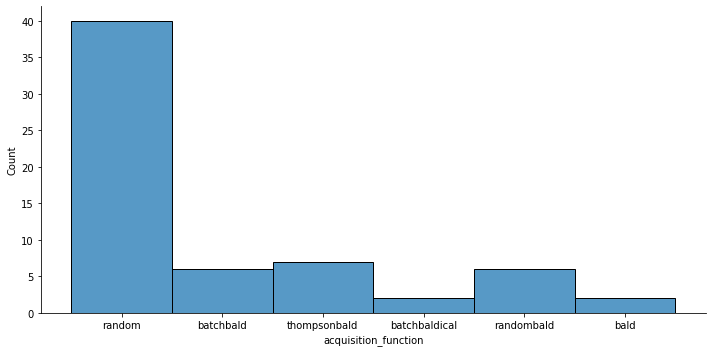

In [ ]:
sns.displot(df.query("training_set_size == 20 and acquisition_size == 5"), x="acquisition_function", aspect=2)

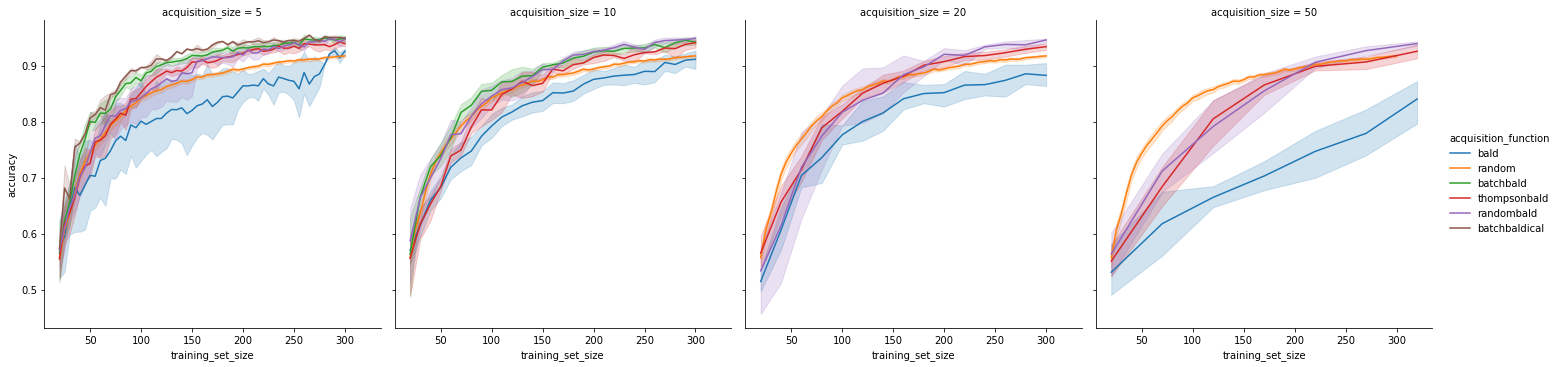

In [ ]:
grd = sns.relplot(
    x="training_set_size",
    y="accuracy",
    col="acquisition_size",
    hue="acquisition_function",
    data=df,
    kind="line",
    height=5,
)

grd.fig.patch.set_alpha(1)